<a href="https://colab.research.google.com/github/hafsaAit/TIME-SERIES-MODELS/blob/main/Models_(ARMA_ARIMA_SARIMAX_AUTO-ARIMA_PROPHET_SKTIME).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TIME SERIES MODELS




### packages

In [ ]:
!pip install pmdarima


In [ ]:
pip install sktime


In [ ]:
pip install --upgrade sktime


In [ ]:
!pip install prophet


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from math import sqrt
from pandas import date_range



### DataFrame


In [ ]:
df = pd.read_excel("RAIB ET LBEN.xlsx")

print(df)
print(df.columns)


    Mois fiscal  Ventes Totales (MAD) TTC
0    01/01/2012                   1394462
1    01/01/2013                   1827957
2    01/01/2014                   1736405
3    01/01/2015                   1821170
4    01/01/2016                   1287729
..          ...                       ...
134  01/12/2018                   1510079
135  01/12/2019                   1550424
136  01/12/2020                   1790322
137  01/12/2021                   1965801
138  01/12/2022                   2308003

[139 rows x 2 columns]
Index(['Mois fiscal', 'Ventes Totales (MAD) TTC'], dtype='object')



### 'Mois fiscal' en format de datetime


In [ ]:
df['Mois fiscal'] = pd.to_datetime(df['Mois fiscal'], format='%d/%m/%Y')

### indexer la colonne 'Mois fiscal'


In [ ]:
df.set_index('Mois fiscal', inplace=True)

###frequency column

In [ ]:
df = df.asfreq('MS')

In [ ]:
print(df)

             Ventes Totales (MAD) TTC
Mois fiscal                          
2011-12-01                     867313
2012-01-01                    1394462
2012-02-01                    1496055
2012-03-01                    1695006
2012-04-01                    1596384
...                               ...
2023-02-01                    1587666
2023-03-01                    3331324
2023-04-01                    4029513
2023-05-01                    2916238
2023-06-01                    2325122

[139 rows x 1 columns]


In [ ]:
df = df.fillna(method="ffill")

### Visualisation de la série temporelle

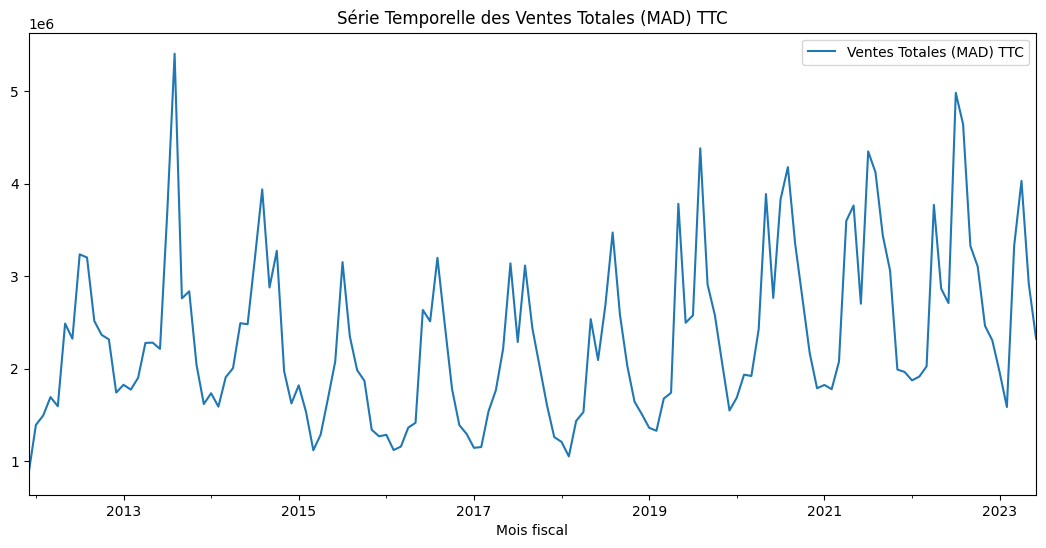

In [ ]:


df.plot(y='Ventes Totales (MAD) TTC', figsize=(13, 6))
plt.title('Série Temporelle des Ventes Totales (MAD) TTC')
plt.show()


### diviser les données ( data train & data test)

In [ ]:
date_fin_train = '2022-10-01'
df_train = df[df.index < date_fin_train].copy()
df_test = df[df.index >= date_fin_train].copy()


### Décompositon de la série temporelle

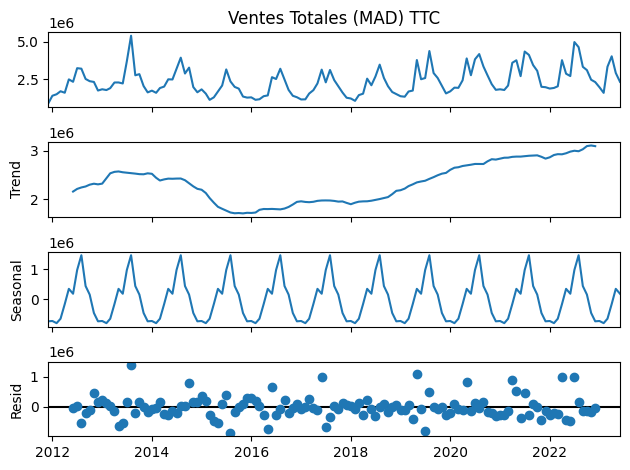

In [ ]:
# @title Visualisation de ( trend & seasonality & resid)

## Extraire la série temporelle des ventes
ts = df['Ventes Totales (MAD) TTC']
# Décomposer la série temporelle
decomposition = seasonal_decompose(ts, model='additive', period=12)
# Afficher la décomposition
fig = decomposition.plot()
plt.show()


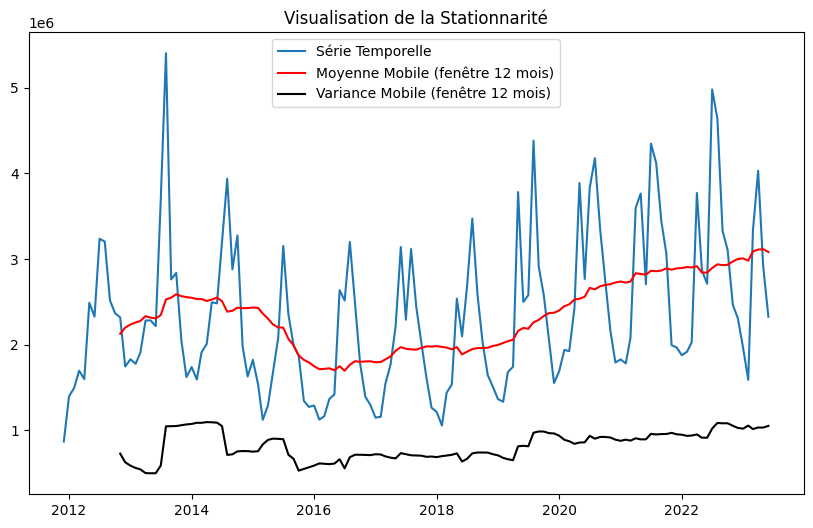

In [ ]:
# @title Visualisation de la Stationnarité

ts = df['Ventes Totales (MAD) TTC']

# Vérifier s'il y a des valeurs manquantes dans la série temporelle
if ts.isnull().any():
    print("Il y a des valeurs manquantes dans la série temporelle.")
else:

    # Calculer la moyenne mobile et la variance mobile
    rolling_mean = ts.rolling(window=12).mean()
    rolling_std = ts.rolling(window=12).std()


    # Tracer la série temporelle, la moyenne mobile et la variance mobile
    plt.figure(figsize=(10, 6))
    plt.plot(ts, label='Série Temporelle')
    plt.plot(rolling_mean, color='red', label='Moyenne Mobile (fenêtre 12 mois)')
    plt.plot(rolling_std, color='black', label='Variance Mobile (fenêtre 12 mois)')
    plt.legend()
    plt.title('Visualisation de la Stationnarité')
    plt.show()


### ACF & PACF

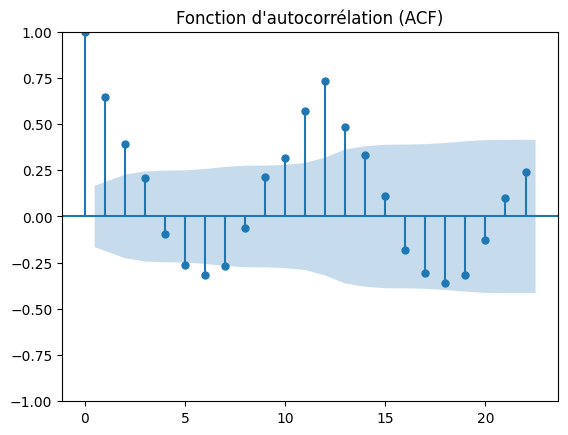

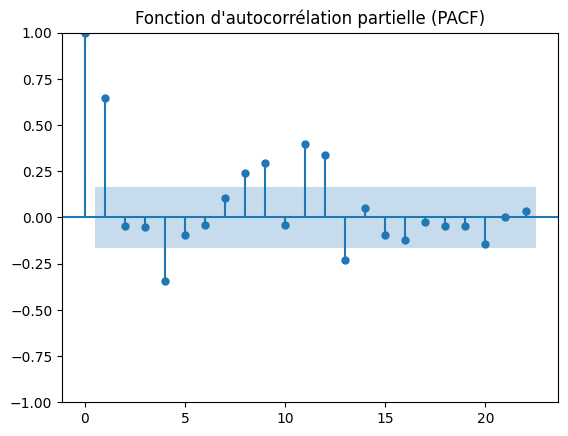

In [ ]:

ts = df['Ventes Totales (MAD) TTC']

# Tracez la fonction d'autocorrélation (ACF)
plot_acf(ts)
plt.title('Fonction d\'autocorrélation (ACF)')
plt.show()

# Tracez la fonction d'autocorrélation partielle (PACF)
plot_pacf(ts)
plt.title('Fonction d\'autocorrélation partielle (PACF)')
plt.show()



### MODEL ARMA

In [ ]:
# @title  MODEL AR

model_ar = ARIMA(ts, order=(12, 0, 0))
model_ar_fit = model_ar.fit()

print(model_ar_fit.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                                  SARIMAX Results                                   
Dep. Variable:     Ventes Totales (MAD) TTC   No. Observations:                  139
Model:                      ARIMA(12, 0, 0)   Log Likelihood               -2010.289
Date:                      Thu, 04 Apr 2024   AIC                           4048.579
Time:                              09:54:05   BIC                           4089.662
Sample:                          12-01-2011   HQIC                          4065.274
                               - 06-01-2023                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.343e+06   4.89e+05      4.789      0.000    1.38e+06     3.3e+06
ar.L1          0.2847      0.078      3.649      0.000       0.132       0.438
ar.L

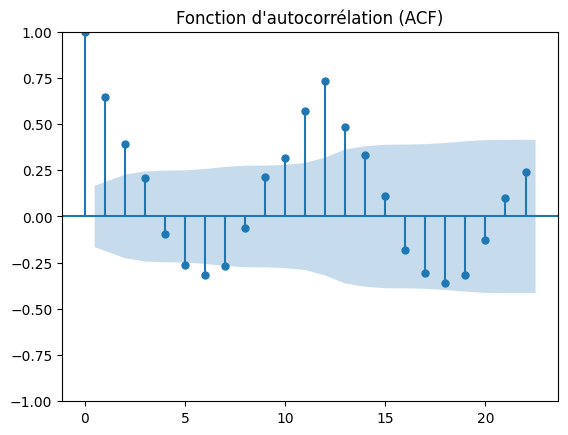

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

# Tracer la fonction d'autocorrélation (ACF)
plot_acf(ts)
plt.title('Fonction d\'autocorrélation (ACF)')
plt.show()


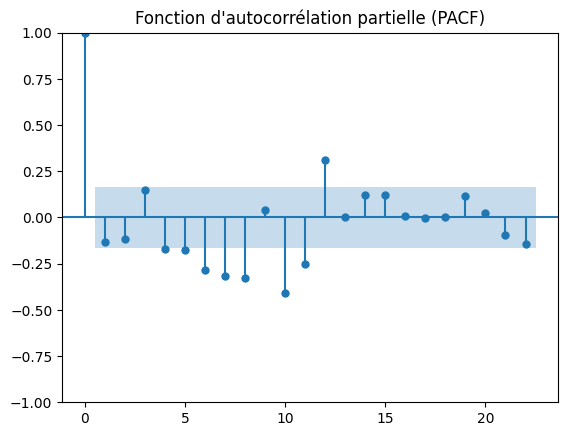

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf


plot_pacf(ts.diff().dropna())
plt.title('Fonction d\'autocorrélation partielle (PACF)')
plt.show()


In [ ]:
# @title  MODEL MA

model_ma = ARIMA(ts, order=(0, 0, 1))
model_ma_fit = model_ma.fit()


print(model_ma_fit.summary())


                                  SARIMAX Results                                   
Dep. Variable:     Ventes Totales (MAD) TTC   No. Observations:                  139
Model:                       ARIMA(0, 0, 1)   Log Likelihood               -2072.358
Date:                      Wed, 03 Apr 2024   AIC                           4150.716
Time:                              11:00:01   BIC                           4159.520
Sample:                          12-01-2011   HQIC                          4154.294
                               - 06-01-2023                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.343e+06   1.16e+05     20.211      0.000    2.12e+06    2.57e+06
ma.L1          0.6353      0.067      9.546      0.000       0.505       0.766
sigm

### ADF (Augmented Dickey–Fuller test)

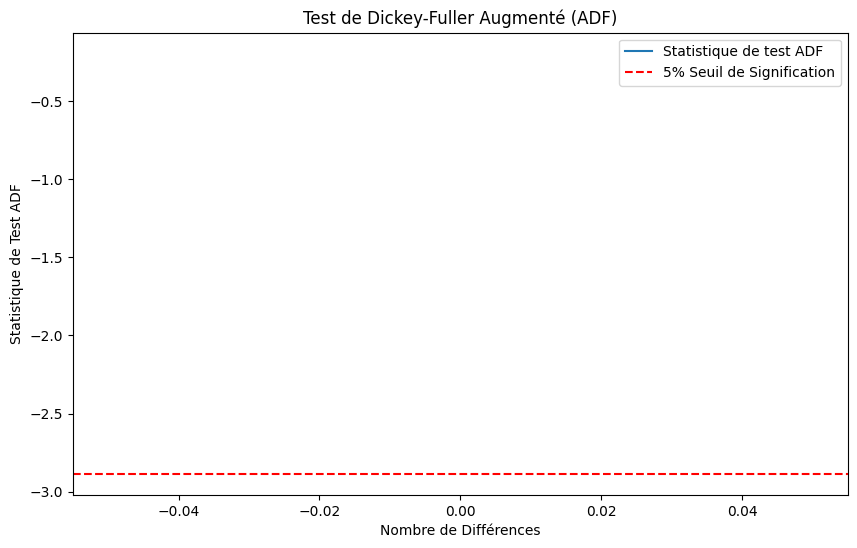

In [ ]:

result = adfuller(ts)

adf_stat = result[0]

plt.figure(figsize=(10, 6))
plt.plot(result[0], label='Statistique de test ADF')
plt.axhline(y=result[4]['5%'], color='r', linestyle='--', label='5% Seuil de Signification')
plt.title('Test de Dickey-Fuller Augmenté (ADF)')
plt.xlabel('Nombre de Différences')
plt.ylabel('Statistique de Test ADF')
plt.legend()
plt.show()


In [ ]:
from statsmodels.tsa.stattools import adfuller

# Effectuer le test de Dickey-Fuller augmenté (ADF)
result = adfuller(ts)

# Extraire la statistique de test et la p-valeur
adf_stat = result[0]
p_value = result[1]

# Imprimer la statistique de test et la p-valeur
print(f'Statistique de test ADF : {adf_stat}')
print(f'p-valeur : {p_value}')

# Interpréter les résultats
if p_value <= 0.05:
    print("La série temporelle est stationnaire ")
else:
    print("La série temporelle n'est pas stationnaire ")


Statistique de test ADF : -0.1967005977360284
p-valeur : 0.9389137563586507
La série temporelle n'est pas stationnaire 


### CALCULE DE PARAMETRE D

In [ ]:

def optimal_determination(ts):
    d = 0
    stationary = False

    # Répéter le test de stationnarité jusqu'à ce que la série temporelle devienne stationnaire
    while not stationary:

        result = adfuller(ts)


        p_value = result[1]

        # Vérifier si la série temporelle est stationnaire (p-valeur <= 0.05)
        if p_value <= 0.05:
            stationary = True
        else:
            # Si la série temporelle n'est pas stationnaire, différencier une fois de plus
            ts = ts.diff().dropna()
            d += 1

    return d


optimal_d = optimal_determination(ts)
print("Nombre optimal de différenciations (d) :", optimal_d)


Nombre optimal de différenciations (d) : 1


### MODEL ARIMA

In [ ]:
# @title  ARIMA

from statsmodels.tsa.arima.model import ARIMA

model_arima = ARIMA(ts, order=(12, 1, 7))
model_arima_fit = model_arima.fit()

print(model_arima_fit.summary())



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                  SARIMAX Results                                   
Dep. Variable:     Ventes Totales (MAD) TTC   No. Observations:                  139
Model:                      ARIMA(12, 1, 7)   Log Likelihood               -1994.305
Date:                      Fri, 05 Apr 2024   AIC                           4028.609
Time:                              09:50:40   BIC                           4087.154
Sample:                          12-01-2011   HQIC                          4052.401
                               - 06-01-2023                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0397      0.357     -0.111      0.911      -0.739       0.659
ar.L2         -0.0904      0.271     -0.333      0.739      -0.622       0.441
ar.L

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# @title Prévisions ARIMA

pred_start_date  = df_test.index[0]
pred_end_date  = df_test.index[-1]

In [ ]:
print(pred_start_date)
print(pred_end_date)

2022-10-01 00:00:00
2023-06-01 00:00:00


In [ ]:
pred = model_arima_fit.predict(start=pred_start_date , end=pred_end_date)

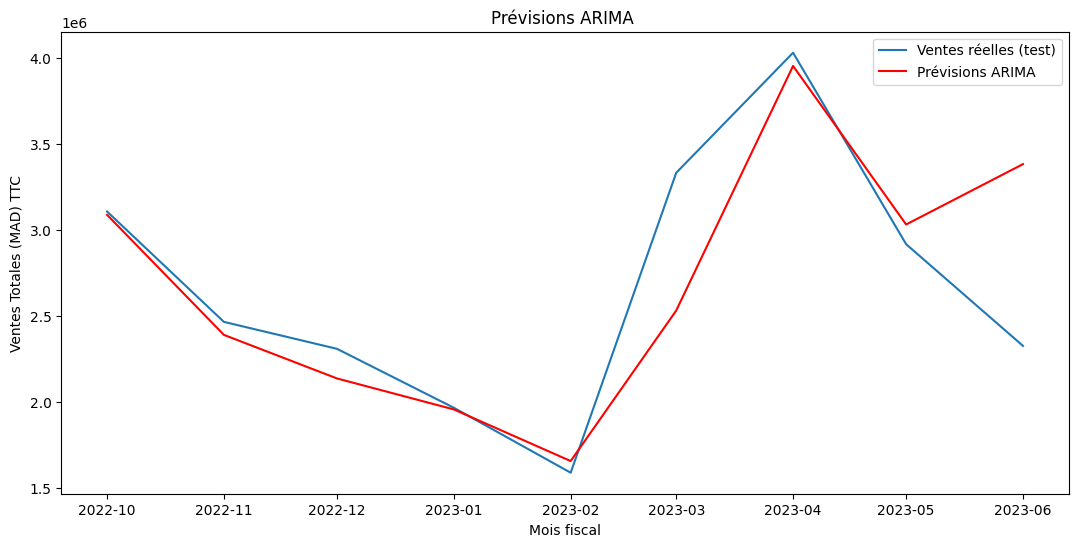

In [ ]:

plt.figure(figsize=(13, 6))
plt.plot(df_test['Ventes Totales (MAD) TTC'], label='Ventes réelles (test)')
plt.plot(pred, label='Prévisions ARIMA', color='red')
plt.title('Prévisions ARIMA ')
plt.xlabel('Mois fiscal')
plt.ylabel('Ventes Totales (MAD) TTC')
plt.legend()
plt.show()


### MODEL SARIMAX

In [ ]:
# @title  SARIMAX


from statsmodels.tsa.statespace.sarimax import SARIMAX

# Créer le modèle SARIMAX avec des spécifications ajustées
model_sarimax = SARIMAX(ts, order=(11, 1, 6), seasonal_order=(11, 1, 6, 12))


model_sarimax_fit = model_sarimax.fit()

print(model_sarimax_fit.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:             Ventes Totales (MAD) TTC   No. Observations:                  139
Model:             SARIMAX(11, 1, 6)x(11, 1, 6, 12)   Log Likelihood               -1815.902
Date:                              Fri, 05 Apr 2024   AIC                           3701.803
Time:                                      09:57:26   BIC                           3801.073
Sample:                                  12-01-2011   HQIC                          3742.133
                                       - 06-01-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4428      0.228     -1.942      0.052      -0.890       0.004
ar.L2          0.00

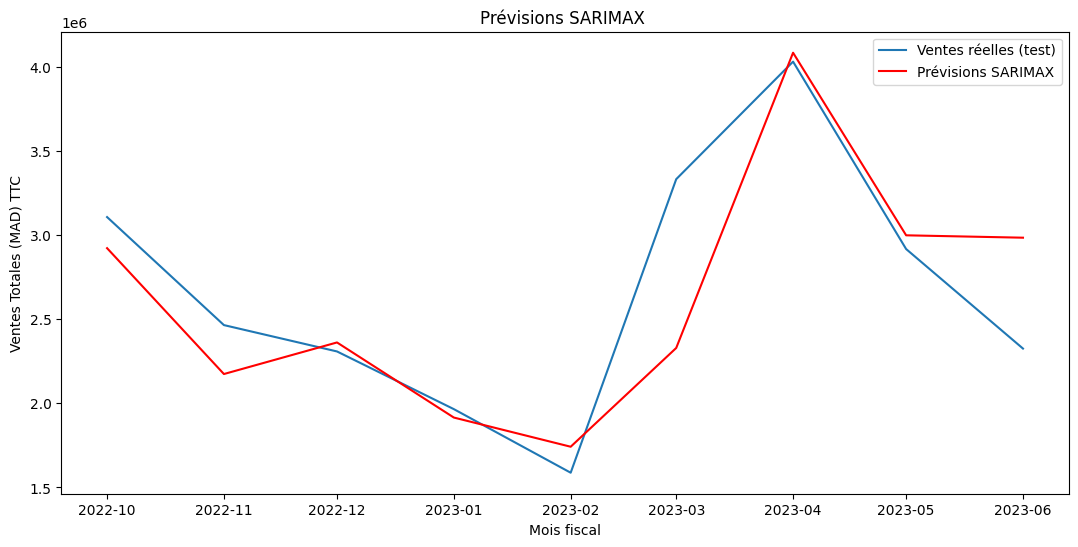

In [ ]:
# @title Prévisions SARIMAX

predi_start_date  = df_test.index[0]
predi_end_date  = df_test.index[-1]

predi = model_sarimax_fit.predict(start=predi_start_date , end=predi_end_date)


plt.figure(figsize=(13, 6))
plt.plot(df_test['Ventes Totales (MAD) TTC'], label='Ventes réelles (test)')
plt.plot(predi, label='Prévisions SARIMAX', color='red')
plt.title('Prévisions SARIMAX ')
plt.xlabel('Mois fiscal')
plt.ylabel('Ventes Totales (MAD) TTC')
plt.legend()
plt.show()

### RMSE POUR ARMIMA & SARIMAX

In [ ]:


arima_predictions = model_arima_fit.predict(start=df_test.index[0], end=df_test.index[-1], dynamic=False)

sarimax_predictions = model_sarimax_fit.predict(start=df_test.index[0], end=df_test.index[-1], dynamic=False)

# Créer une série pandas pour stocker les prédictions avec l'index de dates
arima_predictions_series = pd.Series(arima_predictions, index=df_test.index)
sarimax_predictions_series = pd.Series(sarimax_predictions, index=df_test.index)

# Calculer RMSE avec les prédictions ayant le même index que les valeurs réelles
arima_rmse = sqrt(mean_squared_error(df_test['Ventes Totales (MAD) TTC'], arima_predictions_series))
sarimax_rmse = sqrt(mean_squared_error(df_test['Ventes Totales (MAD) TTC'], sarimax_predictions_series))

arima_rmse_rounded = round(arima_rmse, 2)
sarimax_rmse_rounded = round(sarimax_rmse, 2)

print("RMSE pour ARIMA:", arima_rmse_rounded)
print("RMSE pour SARIMAX:", sarimax_rmse_rounded)

RMSE pour ARIMA: 449387.85
RMSE pour SARIMAX: 421142.77


### MODEL AUTO ARIMA

In [ ]:
# @title AUTO ARIMA

from pmdarima import auto_arima

auto_arima_model = auto_arima(ts, seasonal=True, m=12, trace=True)

print(auto_arima_model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=4068.337, Time=0.83 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4128.251, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=4072.330, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=4082.685, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4126.282, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=4075.670, Time=0.57 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=4066.371, Time=1.26 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=4068.373, Time=1.92 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=inf, Time=3.23 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=4066.848, Time=0.97 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=4065.493, Time=0.86 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=4124.729, Time=0.34 sec
 ARIMA(2,1,1)(2,0,0)[12] intercept   : AIC=4067.492, Time=1.72 sec
 ARIMA(2,1,1)(1,0,1)[12] inte

### MODEL PROPHET



In [ ]:
# @title  PROPHET
from prophet import Prophet


model_prophet = Prophet(seasonality_mode='multiplicative', seasonality_prior_scale=10)
model_prophet.add_seasonality(name='monthly', period=12, fourier_order=5)

df_prophet = df.reset_index().rename(columns={'Mois fiscal': 'ds', 'Ventes Totales (MAD) TTC': 'y'})


model_prophet.fit(df_prophet)



INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjdoteevd/_791m13g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjdoteevd/_0jt6_ar.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73764', 'data', 'file=/tmp/tmpjdoteevd/_791m13g.json', 'init=/tmp/tmpjdoteevd/_0jt6_ar.json', 'output', 'file=/tmp/tmpjdoteevd/prophet_modelr60tx3g7/prophet_model-20240405101428.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:14:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:14:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# @title Prévisions PROPHET
predi_start_date = df_test.index[0]
predi_end_date = df_test.index[-1]


data_test = df_prophet[(df_prophet['ds'] >= predi_start_date) & (df_prophet['ds'] <= predi_end_date)]

prd = model_prophet.predict(data_test)

prd_test = prd[(prd['ds'] >= predi_start_date) & (prd['ds'] <= predi_end_date)]



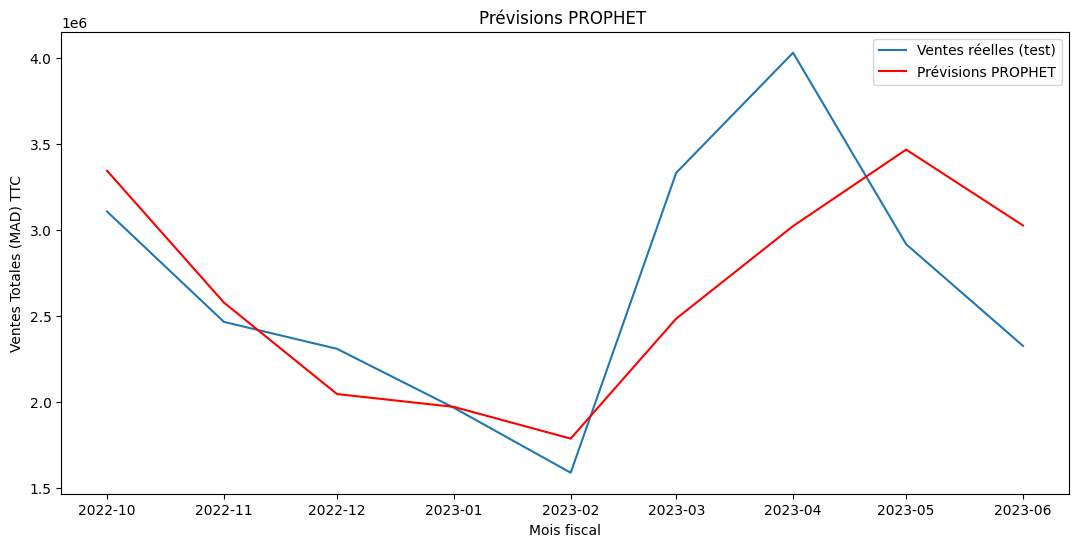

In [ ]:
# @title Prévisions PROPHET
plt.figure(figsize=(13, 6))
plt.plot(df_test['Ventes Totales (MAD) TTC'], label='Ventes réelles (test)')
plt.plot(prd_test['ds'], prd_test['yhat'], label='Prévisions PROPHET', color='red')
plt.title('Prévisions PROPHET ')
plt.xlabel('Mois fiscal')
plt.ylabel('Ventes Totales (MAD) TTC')
plt.legend()
plt.show()

In [ ]:
# @title RMSE PROPHET

merged_df = pd.merge(df_test, prd, left_on='Mois fiscal', right_on='ds', how='inner')

# Sélectionner les colonnes pertinentes pour les prédictions
prophet_predictions_series = merged_df['yhat']

# Filtrer les valeurs réelles de df_test
actual_values = merged_df['Ventes Totales (MAD) TTC']


prophet_rmse = sqrt(mean_squared_error(actual_values, prophet_predictions_series))
prophet_rmse_rounded = round(prophet_rmse, 2)

print("RMSE pour Prophet:", prophet_rmse_rounded)



RMSE pour Prophet: 548199.07


### MODEL SKTIME

In [ ]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

y_train = df_train['Ventes Totales (MAD) TTC']

prediction_model = ExponentialSmoothing()

prediction_model.fit(y_train)



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


ExponentialSmoothing()

In [ ]:

predict_start_date = df_test.index[0]
predict_end_date = df_test.index[-1]


In [ ]:

data_test = y_train[predict_start_date:predict_end_date]


In [ ]:
# Prédiction avec horizon de prévision
fh = len(data_test)


In [ ]:
predi_test = prediction_model.predict(fh=len(data_test), X=data_test)


ValueError: Invalid frequency. Please select a frequency that can be converted to a regular `pd.PeriodIndex`. For other frequencies, basic arithmetic operation to compute durations currently do not work reliably.

### COMPARAISON DES MODELS

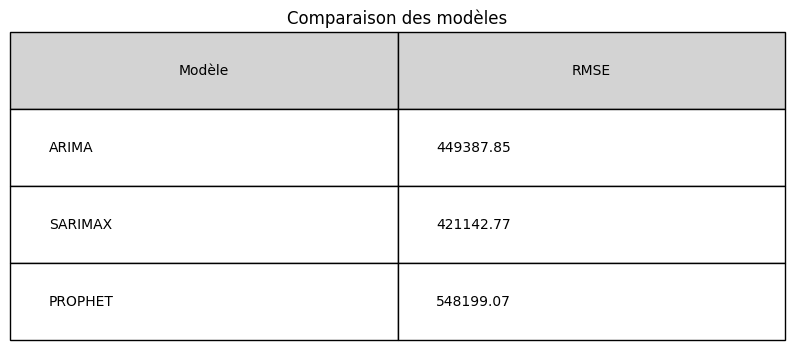


Le modèle le plus performant est: SARIMAX avec un RMSE de: 421142.77 


In [ ]:

results = {
    "Modèle": ["ARIMA", "SARIMAX", "PROPHET"],
    "RMSE": [arima_rmse_rounded, sarimax_rmse_rounded, prophet_rmse_rounded]
}

results_df = pd.DataFrame(results)

best_model = results_df.loc[results_df['RMSE'].idxmin(), 'Modèle']
best_rmse = results_df['RMSE'].min()


fig, ax = plt.subplots(figsize=(10, 4))
ax.axis('tight')
ax.axis('off')
ax.set_title('Comparaison des modèles')

table = ax.table(cellText=results_df.values,
                 colLabels=results_df.columns,
                 bbox=[0, 0, 1, 1],
                 cellLoc='left',
                 colColours=['lightgrey']*len(results_df.columns))


plt.show()


print()


print("\033[1mLe modèle le plus performant est:", best_model, "avec un RMSE de:", best_rmse, "\033[0m")


### Linear Regression Model

In [43]:
from sklearn.linear_model import LinearRegression
lin_model=LinearRegression ()
